In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


D:\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


            WAG_C_M
count    284.000000
mean   12193.308099
std    11992.326701
min       15.300000
25%     1191.000000
50%     7195.000000
75%    21365.250000
max    43408.000000


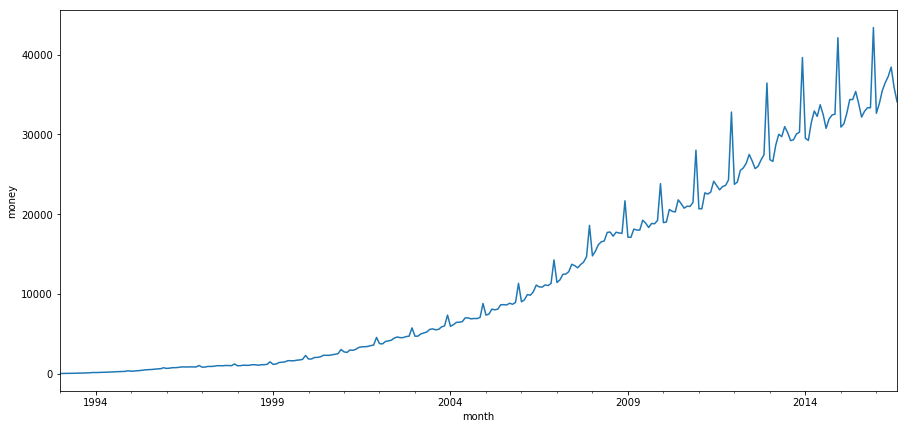

In [2]:
data = pd.read_csv('WAG_C_M.csv',sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data_r = data.WAG_C_M
print( data.describe() )
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel('money')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


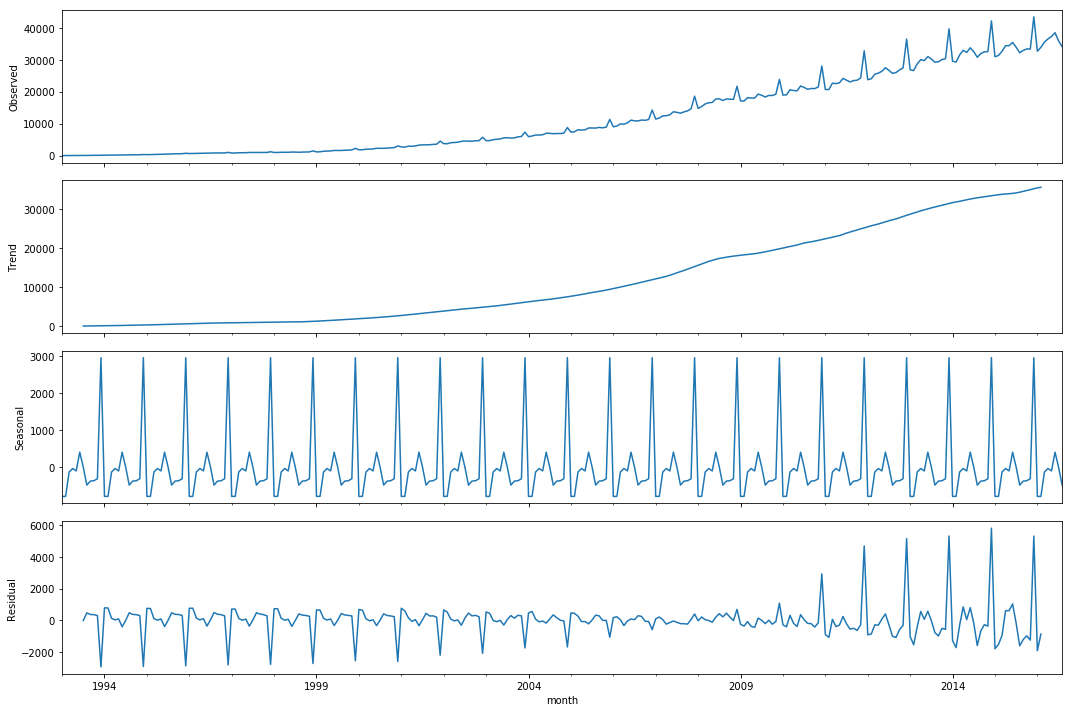

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data_r).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_r)[1])

Критерий Дики-Фуллера неотвергает гипотезу нестационарности ряда. Виден ярковыраженный тренд - зп. увеличивается. В остатках дисперсия не однородна.

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


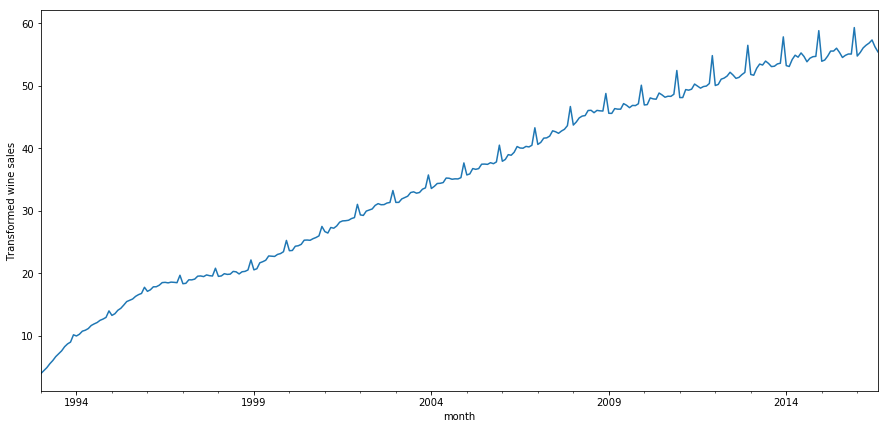

In [4]:
data['money_box'], lmbda = stats.boxcox( data_r )
plt.figure(figsize(15,7))
data.money_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.money_box)[1])

Критерий Дики-Фуллера: p=0.014697


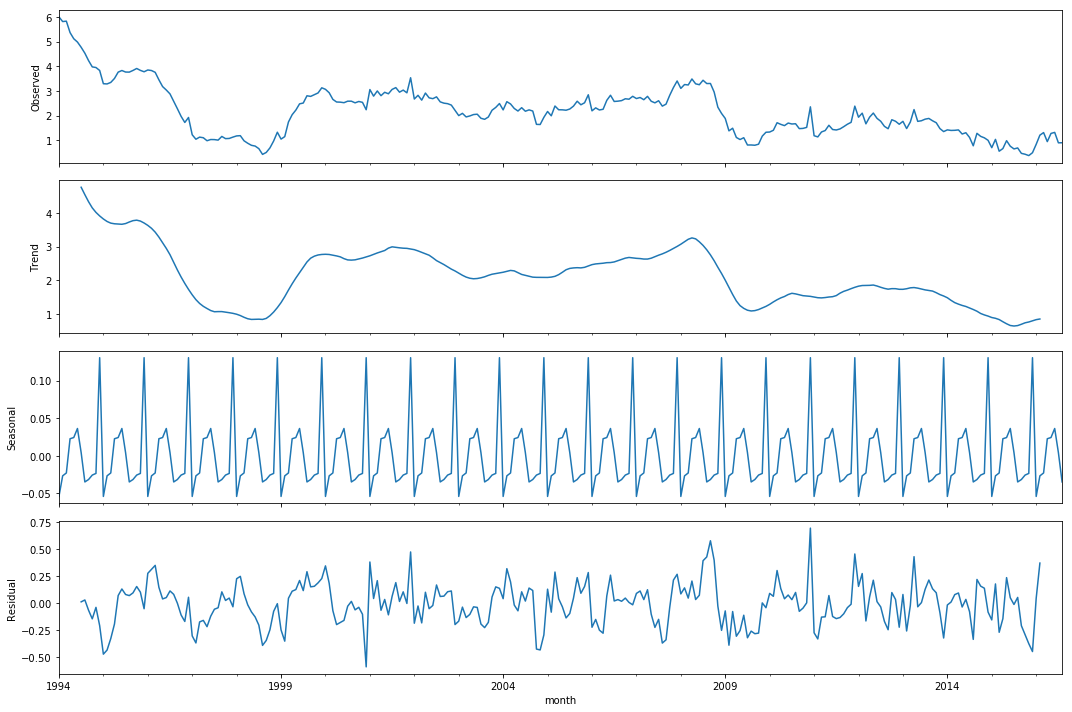

In [5]:
data['money_diff'] = data.money_box - data.money_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.money_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.money_diff[12:])[1])

Критерий Дики-Фуллера: p=0.014697 < 0.05. Считаем получившийся ряд стационарным.
Хотя тренд имеет место быть на отдельных участках, попробуем поработать с такими данными

In [6]:
#data_st = data.money_diff[12:]

построим автокоррелограммы для всего набора данных

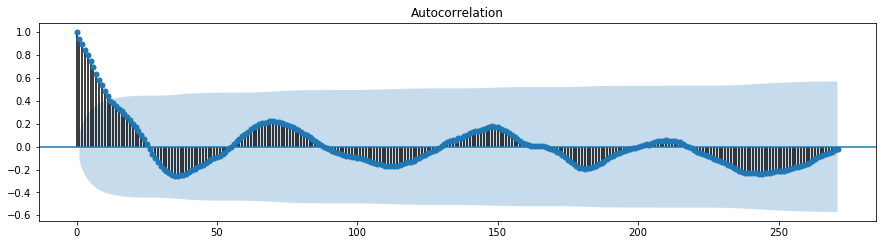

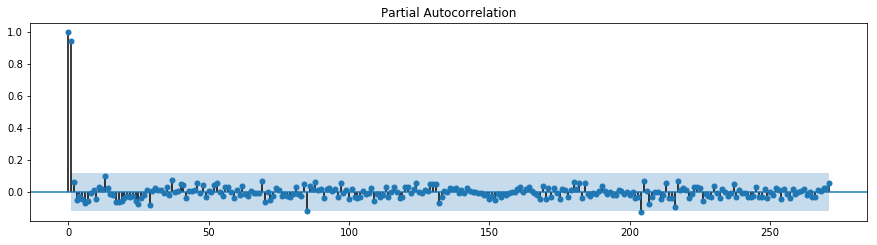

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.money_diff[12:].values.squeeze(), lags=len(data.money_diff[12:])-1, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.money_diff[12:].values.squeeze(), lags=len(data.money_diff[12:])-1, ax=ax)
pylab.show()

а теперь для первых 30

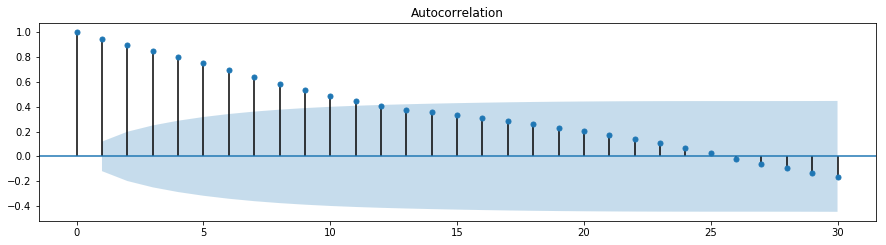

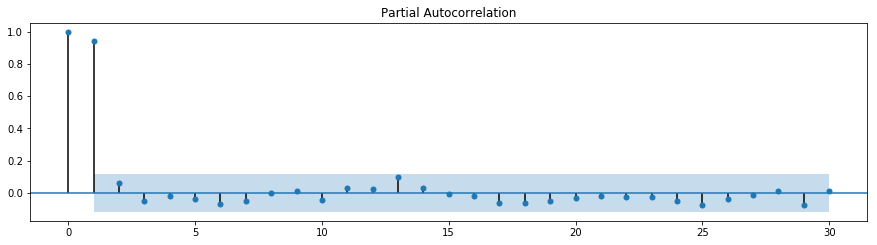

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.money_diff[12:].values.squeeze(), lags=30, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.money_diff[12:].values.squeeze(), lags=30, ax=ax)
pylab.show()

начальные приближения  
Q = 0 - на графике автокорреляции 12 позиция практически на уровне значимости и ее лучше не учитывать
q = 11 - последняя значимая не сезонная автокорреляция  
P=0 - сезонных циклов нет  
p=1 - последняя значимая не сезонная частичная автокорреляция  

In [9]:
ps = range(0, 3)
d=1
qs = range(0, 12)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

Ищем наилучшую модель

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX( data.money_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 5, 0, 0))
('wrong parameters:', (2, 5, 0, 1))
('wrong parameters:', (2, 5, 1, 0))
('wrong parameters:', (2, 5, 1, 1))
Wall time: 8min 8s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
70   (1, 5, 1, 1)  195.071693
42  (0, 10, 1, 1)  195.868792
38   (0, 9, 1, 1)  195.935730
62   (1, 3, 1, 1)  196.290974
86   (1, 9, 1, 1)  196.760713


In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         money_diff   No. Observations:                  284
Model:             SARIMAX(1, 1, 5)x(1, 1, 1, 12)   Log Likelihood                 -88.536
Date:                            Mon, 04 Dec 2017   AIC                            195.072
Time:                                    23:35:20   BIC                            227.912
Sample:                                01-01-1993   HQIC                           208.238
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6031      0.173      3.477      0.001       0.263       0.943
ma.L1         -0.7977      0.180   

По результатам видим, что сезонный лаг можно было брать 1 - т.е. учесть автокорреляцию, а q было завышено.

Смотрим на остатки

Критерий Стьюдента: p=0.975115
Критерий Дики-Фуллера: p=0.000000


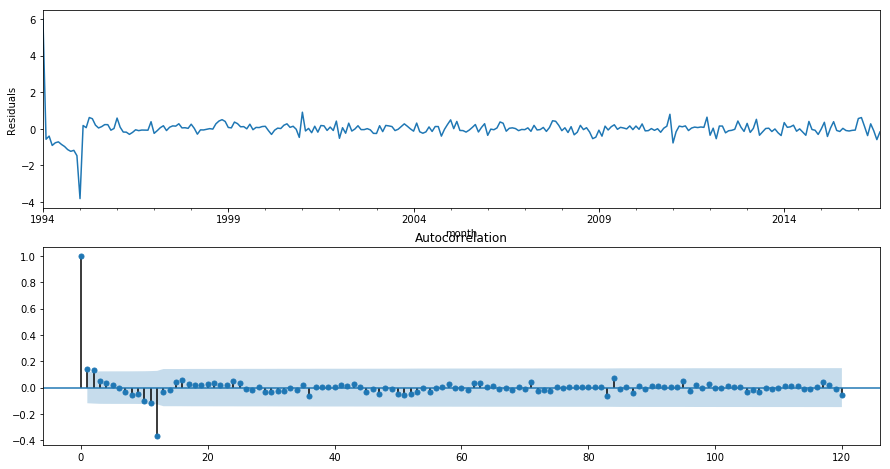

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=120, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

видим - что-то пошло не так. В начале рада есть заметная автокорреляция. Т.е. модель плохо предсказывает зп. в начале. Посмотрим на ситуцию остатков после 1995 года

Критерий Стьюдента: p=0.118744
Критерий Дики-Фуллера: p=0.000000


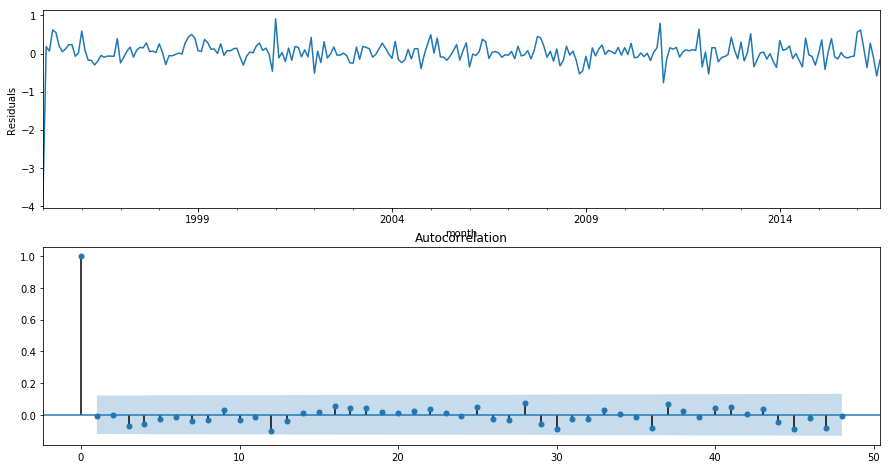

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[24:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[24:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[48:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), хотя значение p стало меньше, стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
  
Получаем что модель хорошо предсказывает данные после 1995 года, данные за первые несколько лет можно выкинуть, т.к. они не влеяют на прогноз через 20 лет.



На практике оказалось что выкинуть можно только первый год, если избавляться от большего количества данных, то критерий Дики-Фуллера для них не выполняется, после снятия сезонности. 
Избавляемся от данных за первый год и делаем анализ ряда с начала.


Оптимальный параметр преобразования Бокса-Кокса: 0.250349
Критерий Дики-Фуллера: p=0.612583


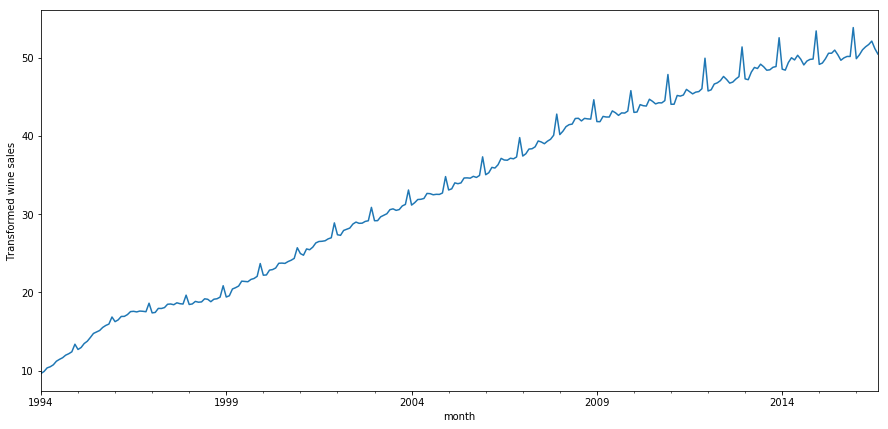

In [15]:
n_item_skip = 1*12
data = pd.read_csv('WAG_C_M.csv',sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data = data.drop([data.index[ix] for ix in range(n_item_skip)]) # удаляем 12 значения - первый год
data['money_box'], lmbda = stats.boxcox( data.WAG_C_M )
plt.figure(figsize(15,7))
data.money_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.money_box)[1])

Критерий Дики-Фуллера: p=0.006628


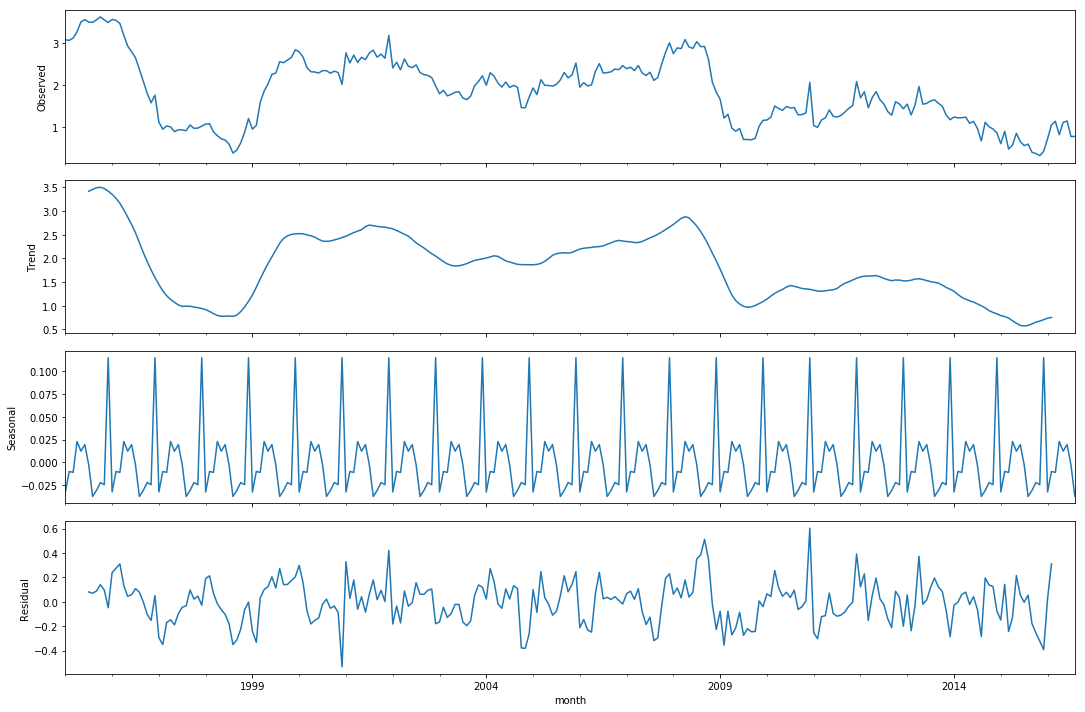

In [16]:
data['money_diff'] = data.money_box - data.money_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.money_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.money_diff[12:])[1])

Критерий Дики-Фуллера: p=0.006628 - критерий уверенно отвергает гипотезу не стационарности ряда, хотя у меня большие сомнения - если удалить данные за 2 года, то он будет примерно 0.1 - может разные значения преобразования Бокса-Кокса влияют на это.

Выбираем значения Q q P p - сезоных циклов нет.  q p берем 11 и 1 соответсвенно.

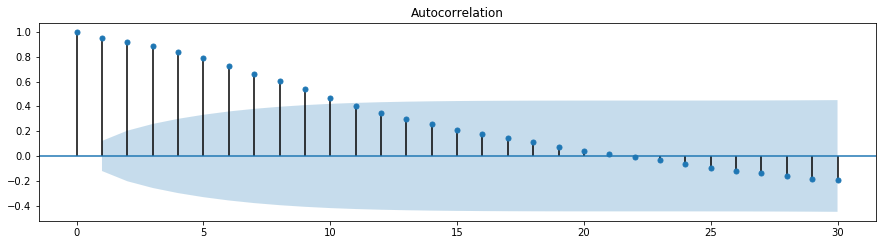

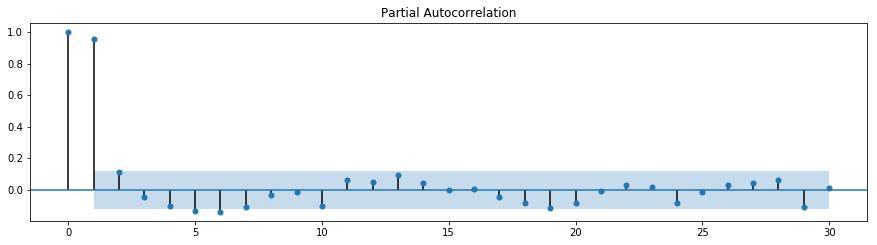

In [17]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['money_diff'][12:].values.squeeze(), lags=30, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['money_diff'][12:].values.squeeze(), lags=30, ax=ax)
pylab.show()

In [18]:
ps = range(0, 3)
d=1
qs = range(0, 11)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

132

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX( data.money_diff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (2, 5, 0, 0))
('wrong parameters:', (2, 5, 0, 1))
('wrong parameters:', (2, 5, 1, 0))
('wrong parameters:', (2, 5, 1, 1))
Wall time: 6min 36s


In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
66   (1, 5, 1, 1)  138.202336
42  (0, 10, 1, 1)  139.132596
58   (1, 3, 1, 1)  139.953924
26   (0, 6, 1, 1)  140.095667
38   (0, 9, 1, 1)  140.168501


In [21]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         money_diff   No. Observations:                  272
Model:             SARIMAX(1, 1, 5)x(1, 1, 1, 12)   Log Likelihood                 -60.101
Date:                            Mon, 04 Dec 2017   AIC                            138.202
Time:                                    23:42:01   BIC                            170.655
Sample:                                01-01-1994   HQIC                           151.231
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.190      3.018      0.003       0.201       0.945
ma.L1         -0.7944      0.200   

Критерий Стьюдента: p=0.865981
Критерий Дики-Фуллера: p=0.000000


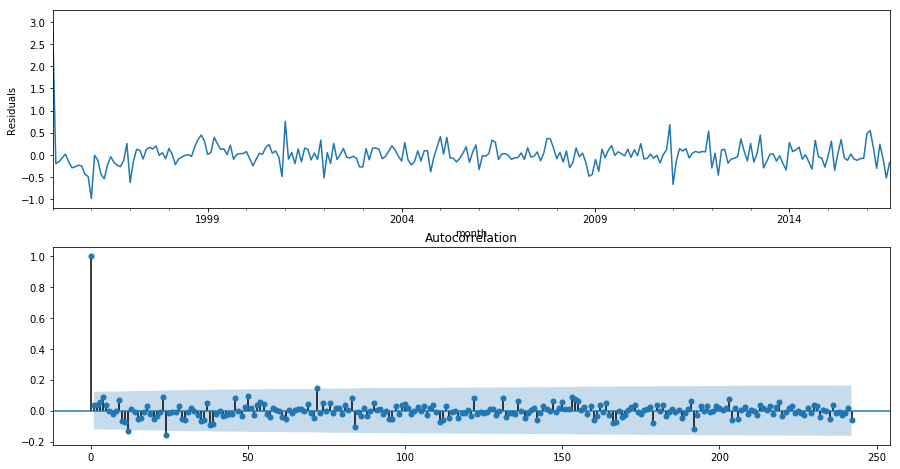

In [22]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=len(best_model.resid)-30, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой - есть корреляции больше 0.05, но они не сильно больше, да еще и сосредоточены в первой четверти данных, а в более позднем отрезке времени нет явных корреляция, думаю модель можно испльзовать).
  
Посмотрим, насколько хорошо модель описывает данные.
Для получения значений нам нужно добавить сезонность и сделать обратное преобразование Бокса-Кокса

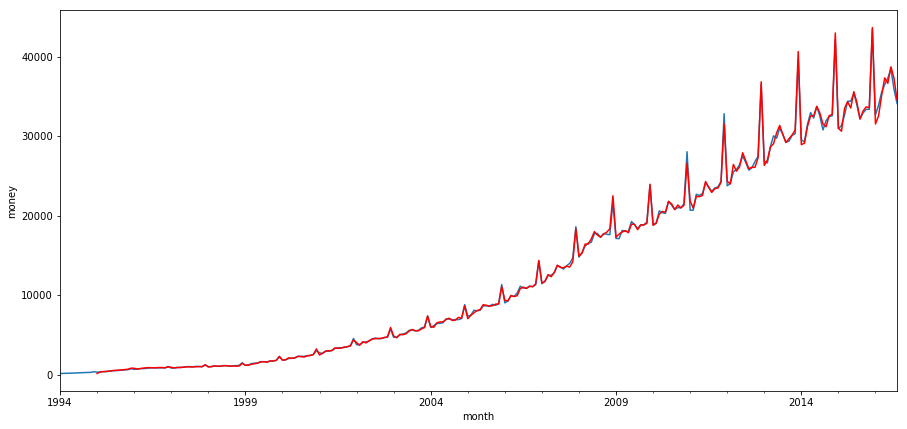

In [23]:
data['model'] = invboxcox(best_model.fittedvalues +  data.money_box.shift(12)[n_item_skip:], lmbda)# т.к. для обучения модели
# испльзовались данные с отрезанными первыми 24 значениями, то сейчас мы убираем первые 24 значений ( Nan )
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[12:].plot(color='r')
plt.ylabel('money')
pylab.show()

Данные модели хорошо ложатся на реальные данные

In [24]:
data.index[-3:]# даты последних данных

DatetimeIndex(['2016-06-01', '2016-07-01', '2016-08-01'], dtype='datetime64[ns]', name=u'month', freq=None)

In [25]:
def reSeasonData( prd_vals, orig_data): # добавление сезонных данных
    add_season = orig_data[-12:]
    for inx in range(min(12,len(prd_vals))):# для первых 12 предсказаний добавляем реальные данные
        prd_vals[inx] += add_season[inx]
    if len(prd_vals)<=12: return
    for inx in range(12,len(prd_vals)): # для следующих добавочное значение берем из предсказынных данных
        prd_vals[inx]+= prd_vals[inx-12]
    return

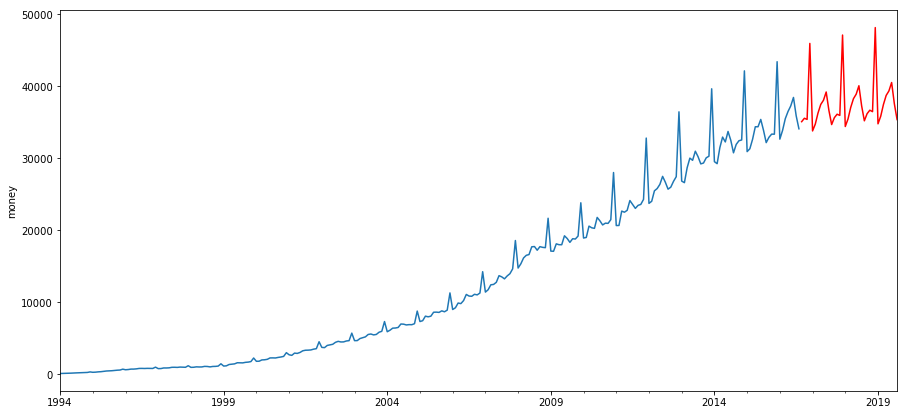

In [26]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
start_pos = len(data)
predict_data = best_model.predict(start=start_pos, end=start_pos+36)
reSeasonData( predict_data, data.money_box)

data2['forecast'] = invboxcox(predict_data, lmbda)

plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('money')
pylab.show()